# Introduction: Business Problem 

In this project we will try to predict the monthly rental price for a condominium. Specifically, this report will be targeted to stakeholders interested in finding the best value in renting a condominium in Singapore.

We will use our data science powers to find optimum rental price and recommend stake holders the best values and similar units for the stakeholders.

# Evalution metrics

## RMSE

In this project, **RMSE** will be our **main metrics** to evaluate the for selecting the best model and evaluate the performance of the best model. For the following reason

1. **RMSE** is chosen as it punishes predicteed value that has greater difference than the actual value. This is important as we do not want our model to undervalue or overvalue a rental unit.

2. **RMSE** gaves us a better intuition of the error which is in the same unit of our response variable (price). In other words, the error tells us how much "wrong" we are in terms of dollar value from the actual value.

The RMSE of predicting each observation as the mean of total observation is SGD 4444. Hence, our model should aim to predict better than RMSE of SGD 4444. 

Refer Section Baseline RMSE score for details.

### Adjusted $R^{2}$

Althought **RMSE** gave us the intuition of how "wrong" is the model prediction in terms of dollar value, performance of the model is not that obvious. Hence, we will be using adjusted $R^{2}$ to give an overall picture of how well is our model performing.

### Success Criteria

The ground truth of the impact of wrongly predicted value are unknown, and not part of the scope of this project.
However, We aim to perform better than guessing the average price of entire condominium rental price in our dataset. (Baseline).

# Import and Setting

In [82]:
import pandas as pd
import numpy as np
from IPython.display import display

from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder, OrdinalEncoder, RareLabelEncoder
import feature_engine.transformation as vt
from feature_engine.selection import RecursiveFeatureElimination

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from xgboost import XGBRegressor

from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from statsmodels.stats.outliers_influence import variance_inflation_factor

import folium
from folium.plugins import MarkerCluster
import branca


import geojson

import math

import seaborn as sns

# Feature Engineering

From the summary of EDA we have found that:-
1. We have found that there is no correlation between counts of amenities & rental price.
2. Rental price for having 'clubhouse', 'parking', 'jacuzzi' is significantly difference. We will create a feature using OneHotEncoding technique for this amenities.
3. Having nearby MRT is siginicant for monthly rental.
4. MRT name has high cardinality. In Feature engineering, we will use Rarelabel encoding technique to group rare MRT occurance under OTHERS.
5. Handling multicolinearity: Select (Walking time, bedrooms & bathrooms) or (Walking time & sqft).
6. For building linear Regression model, we will transform variable to normality by using BoxCoxTransformation.

We will perform feature engineering to address above observation

### Feature Engineering-1: CountVectorized for  clubhouse, parking & jacuzzi

In [2]:
df_train = pd.read_pickle('Data/df_train')
df_test = pd.read_pickle('Data/df_test')

In [3]:
df_train.head(2)

,detailed_address,lat,long,bedrooms,bathrooms,sqft,built_year,amenities,mrt_name,building_name,tenure,link,picture_url,price_month,walking_time,distance,studio,district_number
6152,9 Cairnhill Road,1.302997,103.837785,2.0,2.0,1044,2017.0,"[Clubhouse, Spa pavilion, Swimming pool, Wadin...",Somerset MRT,Cairnhill Nine,0,https://www.99.co/singapore/rent/property/cair...,https://www.99.co/static/v3/icons/clubhouse@3x...,7000,10.0,416.0,0,9
2957,16 Enggor Street,1.274241,103.844755,1.0,1.0,603,2014.0,"[Clubhouse, Basketball court, Aircon, Gym, Bed...",Tanjong Pagar MRT,Altez,0,https://www.99.co/singapore/rent/property/alte...,https://www.99.co/static/v3/icons/clubhouse@3x...,4500,5.0,253.0,0,2


In [4]:
# remove all amenities in listing except clubhouse, parking and jaccuzi
def relevantamenities(x: list):
    
    relevant = ['Clubhouse', 'Parking', 'Jacuzzi']
    
    return [amenity for amenity in x if amenity in relevant]

In [5]:
df_train['amenities'] = df_train.amenities.apply(relevantamenities)
df_test['amenities'] = df_test.amenities.apply(relevantamenities)

In [6]:
#transform the amenities into feature
ct = make_column_transformer(
    (CountVectorizer(analyzer=lambda x: x), 'amenities'),
    remainder = 'passthrough',
)


In [7]:
df_train = pd.DataFrame(ct.fit_transform(df_train), columns=ct.get_feature_names())
df_test = pd.DataFrame(ct.transform(df_test), columns=ct.get_feature_names())

### Feature-Engineering 2: Having MRT is significant to monthly rental

In [8]:
df_train['mrt_availability'] = np.where(df_train['mrt_name'] == 'No_MRT', 0, 1)
df_test['mrt_availability'] = np.where(df_test['mrt_name'] == 'No_MRT', 0, 1)

### Feature-Engineering 3: Group rare MRT occurance under OTHERS & OneHOT Encoding

In [9]:
#RareLabel Encoding
rare_encoder = RareLabelEncoder(
    tol=0.005,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['mrt_name'], # variables to re-group,
    replace_with='Others'
)

In [10]:
df_train = rare_encoder.fit_transform(df_train)
df_test = rare_encoder.transform(df_test)

In [11]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['mrt_name'],  # we can select which variables to encode
    drop_last=False)

In [12]:
df_train = ohe_enc.fit_transform(df_train)
df_test = ohe_enc.transform(df_test)

In [13]:
#recast datatype to numerical
for col in df_train:
    df_train[col] = pd.to_numeric(df_train[col], errors='ignore')
    df_test[col] = pd.to_numeric(df_test[col], errors='ignore')

### Feature Engineering - 4 Target guided Encoding for District

In [14]:
ordinal_enc = OrdinalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables=['district_number'],
    ignore_format = True)

In [15]:
ordinal_enc.fit(df_train, df_train['price_month'])
df_train = ordinal_enc.transform(df_train)
df_test = ordinal_enc.transform(df_test)

### Feature Engineering - 5 Handling Multicolinearity

In [16]:
#we will combine bathrooms & bedrooms to handline multicolinearity, for other feature, it will be dropped instead
df_train['total room'] = df_train['bathrooms'] + df_train['bedrooms']
df_test['total room'] = df_test['bathrooms'] + df_test['bedrooms']

### Feature-Engineering 6: BoxCox Transformation for LinearRegression

In [17]:
continuous_variables = ['price_month', 'bedrooms', 'bathrooms', 'total room', 'sqft', 'walking_time', 'distance']

In [18]:
bct = vt.BoxCoxTransformer(variables = continuous_variables)
df_train_lr = bct.fit_transform(df_train)
df_test_lr = bct.transform(df_test) 

In [19]:
# these are the exponents for the BoxCox transformation
bct.lambda_dict_

{'price_month': -0.014444710502950238,
 'bedrooms': 0.34990443094029966,
 'bathrooms': 0.01507637030264619,
 'total room': 0.2206802857205239,
 'sqft': -0.11785532339089105,
 'walking_time': -0.3970483191451235,
 'distance': -0.19970443417532519}

In [20]:
#final look of the transformed train dataframe
df_train = df_train.drop(['detailed_address', 'lat', 'long', 'bedrooms', 'bathrooms', 'distance', 'link', 'picture_url', 'building_name'], axis=1)
df_train.head(2)

,countvectorizer__Clubhouse,countvectorizer__Jacuzzi,countvectorizer__Parking,sqft,built_year,tenure,price_month,walking_time,studio,district_number,...,mrt_name_Rochor MRT,mrt_name_Potong Pasir MRT,mrt_name_Eunos MRT,mrt_name_Dakota MRT,mrt_name_Kembangan MRT,mrt_name_Toa Payoh MRT,mrt_name_Chinatown MRT,mrt_name_Stadium MRT,mrt_name_Lakeside MRT,total room
0,1,0,0,1044,2017.0,0,7000,10.0,0,24,...,0,0,0,0,0,0,0,0,0,4.0
1,1,0,0,603,2014.0,0,4500,5.0,0,19,...,0,0,0,0,0,0,0,0,0,2.0


In [21]:
#final look of the transformed train dataframe
df_test = df_test.drop(['detailed_address', 'lat', 'long', 'bedrooms', 'bathrooms', 'distance', 'link', 'picture_url', 'building_name'], axis=1)
df_test.head(2)

,countvectorizer__Clubhouse,countvectorizer__Jacuzzi,countvectorizer__Parking,sqft,built_year,tenure,price_month,walking_time,studio,district_number,...,mrt_name_Rochor MRT,mrt_name_Potong Pasir MRT,mrt_name_Eunos MRT,mrt_name_Dakota MRT,mrt_name_Kembangan MRT,mrt_name_Toa Payoh MRT,mrt_name_Chinatown MRT,mrt_name_Stadium MRT,mrt_name_Lakeside MRT,total room
0,0,0,1,3347,2010.0,1,18000,10.0,0,24,...,0,0,0,0,0,0,0,0,0,8.0
1,0,0,0,377,2015.0,1,2100,35.0,0,17,...,0,0,0,0,0,0,0,0,0,3.0


# Modelling

In [22]:
# we will create a nested cross validation, the inner_cv will be used to select the best hyperparameter 
# and the outer cv will be used for model selection.
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

## Baseline RMSE Score

In [23]:
df_train['baseline'] = df_train.price_month.mean()

In [24]:
np.round(mean_squared_error(df_train['price_month'], df_train['baseline'], squared = False))

4444.0

Baseline rmse score of predicting each observation as the mean of our training sample is SGD 4444

In [25]:
#create a dataframe to store result
all_results = pd.DataFrame(columns= ['rmse_mean', 'rmse_std', 'adjusted_r2_mean', 'adjusted_r2_std'])

## Linear Regression

It is to be noted that Multiple Iteration in selecting feature has been performed to handle multi-colinearity however the intemerdiate steps are not shown, only the final result is shown.

In [26]:
y_train_lr = df_train_lr['price_month']

#drop feature that is relevant / multiconearity

X_train_lr = df_train_lr[['countvectorizer__Clubhouse', 'countvectorizer__Jacuzzi',
    'countvectorizer__Parking', 'tenure', 'sqft', 'studio', 'district_number']]

In [27]:
#reverse transform of box-cox of monthly_rental
#source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
def inverse_transform(X_trans, lambda_):
    if lambda_ == 0:
        X = exp(X_trans)
    else:
        X = (X_trans * lambda_ + 1) ** (1 / lambda_)
    return X

#### Adjusted R2

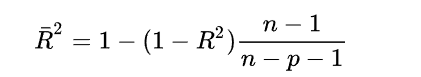

In [28]:
def modified_r2score(y_true, y_pred, p):
    
    n = y_true.shape[0]
    
    r2 = r2_score(y_true, y_pred)
    
    modify_r2 = 1 - (1 - r2)*(n - 1) / (n - p - 1)
    
    return modify_r2
    

#### Linear Regression Result

In [29]:
#we will create our own cross validation as we need the result to be returned in original unit (eg: inverse transform of boxcox)

mean_adjusted_r2 = []
mean_rmse = []

# 5-fold cross validation
for train_index, validation_index in outer_cv.split(X_train_lr):
    
    #setting index of cross validation
    X_train, X_validation = X_train_lr.iloc[train_index], X_train_lr.iloc[validation_index]
    y_train, y_validation = y_train_lr.iloc[train_index], y_train_lr.iloc[validation_index]
    
    #fitting linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    #predict based on X_validation
    y_pred = lr.predict(X_validation)
    
    #reverse transform of boxcox
    y_pred = inverse_transform(y_pred, bct.lambda_dict_['price_month'])
    y_validation = inverse_transform(y_validation, bct.lambda_dict_['price_month'])
    
    #calculating metrics
    adjusted_r2 = modified_r2score(y_validation, y_pred, X_train_lr.shape[1])
    rmse = mean_squared_error(y_validation, y_pred, squared=False)
    
    #appending metrics
    mean_adjusted_r2.append(adjusted_r2)
    mean_rmse.append(rmse)

In [30]:
lr_rmse_mean = np.round(np.mean(mean_rmse))
lr_rmse_std = np.round(np.std(mean_rmse))
lr_r2_mean = np.round(np.mean(mean_adjusted_r2),2)
lr_r2_std = np.round(np.std(mean_adjusted_r2),2)

lr_series = pd.Series([lr_rmse_mean, lr_rmse_std, lr_r2_mean, lr_r2_std], index = all_results.columns, name = 'LinearRegression')

all_results = all_results.append(lr_series)

print('LinearReg_mean_RMSE:', lr_rmse_mean)
print('LinearReg_std_RMSE:', lr_rmse_std)
print('LinearReg_mean_Adjusted R^2:', lr_r2_mean)
print('LinearReg_std_Adjusted R^2:', lr_r2_std)

LinearReg_mean_RMSE: 2603.0
LinearReg_std_RMSE: 220.0
LinearReg_mean_Adjusted R^2: 0.65
LinearReg_std_Adjusted R^2: 0.02


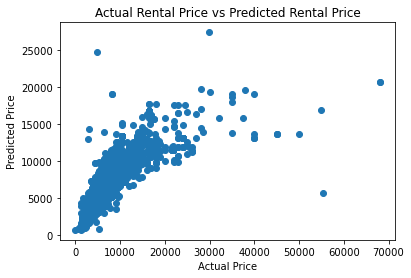

In [31]:
#refit
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)
y_pred = lr.predict(X_train_lr)
y_pred = inverse_transform(y_pred, bct.lambda_dict_['price_month'])

# Visualizing actual prices vs predicted values
plt.scatter(df_train['price_month'], y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Rental Price vs Predicted Rental Price")
plt.show()

### Performing checks for multi-linear regression assumptions

1. **Linearity**: The mean values of the outcome variable for each increment of the predictor(s) lie along a straight line. In other words, there is a linear relationship between predictors and target.

2. **No perfect multicollinearity**: There should be no perfect linear relationship between two or more of the predictors.

3. **Normally distributed errors**: the residuals are random, normally distributed with a mean of 0.

4. **Homoscedasticity**: The variance of the residual terms should be constant.

#### Equal Error Variance (Homoscedasticity)

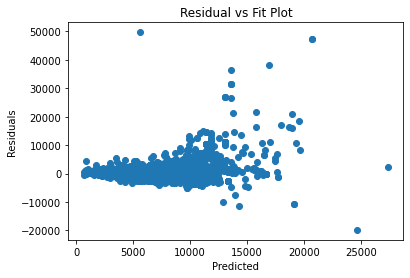

In [32]:
# Residual vs fit plot
plt.scatter(y_pred, df_train['price_month'] - y_pred)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

We can see that there is an increase variance when as the predicted value increase, this suggest that the relationship is not linear

#### Multi-Collinearity

We can see that there is an increasing variance as the price increased. This shows that the relationship might not be linear

In [33]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [34]:
calc_vif(X_train_lr)

,variables,VIF
0,countvectorizer__Clubhouse,1.945240
1,countvectorizer__Jacuzzi,1.774699
2,countvectorizer__Parking,1.829914
3,tenure,2.087982
4,sqft,14.150968
5,studio,1.030896
6,district_number,11.124591


There is no multicolinearity ( VIF < 10)

#### Normal Error (Multivariate Normality)

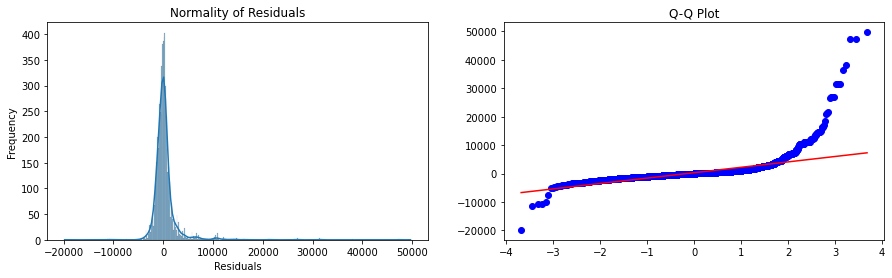

In [35]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,4))

#histogram
sns.histplot(df_train['price_month'] - y_pred, ax=ax[0], kde=True)
ax[0].set_title('Normality of Residuals')
ax[0].set_xlabel("Residuals")
ax[0].set_ylabel("Frequency")

#Q-Q plot
stats.probplot(df_train['price_month'] - y_pred, dist='norm', plot=ax[1])
ax[1].set_title('Q-Q Plot')
ax[1].set_xlabel("")
ax[1].set_ylabel("");


Normality of the distribution of the residual is preserved until a certain threshold.

### Summary of Linear Regression

1. 3/4 assumptions of linear regression is violated except for Multicolinearity.
In order to use linear regression, we need to validate our prediction within a certain threshold.

2. RMSE is \\$2600 which is better than the baseline of \\$4444, Adjusted_R2 is 0.64

## Support Vector Regression

In [36]:
svr = SVR(kernel='poly')

In [37]:
X_train = df_train[['sqft', 
                    'countvectorizer__Clubhouse', 
                    'countvectorizer__Jacuzzi', 
                    'countvectorizer__Parking',
                   'built_year',
                   'tenure',
                   'walking_time',
                   'district_number',
                   'mrt_availability',
                   'total room']]
feature = X_train.columns
y_train = df_train['price_month']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [38]:
params = {'kernel' : ['linear', 'poly'],
          'degree' : [2 , 3],
          'epsilon' : [0.1, 0.5, 1, 5, 10],
          'C' : [1000, 5000, 10000]   
}

In [39]:
svc = GridSearchCV(svr, param_grid= params, cv=inner_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)



score = cross_validate(svc, X_train, y_train, cv=outer_cv, scoring='neg_root_mean_squared_error', return_estimator=True, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.5min finished


In [40]:
for i in range(5):
    print('bestscore:', score['test_score'][i])
    print('bestparam:', score['estimator'][i].best_params_)
    print('****************************************************************')

bestscore: -2468.490709598181
bestparam: {'C': 10000, 'degree': 2, 'epsilon': 5, 'kernel': 'linear'}
****************************************************************
bestscore: -2120.1920997219054
bestparam: {'C': 10000, 'degree': 2, 'epsilon': 10, 'kernel': 'linear'}
****************************************************************
bestscore: -2070.522091739476
bestparam: {'C': 5000, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'}
****************************************************************
bestscore: -2100.3735957805407
bestparam: {'C': 10000, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'}
****************************************************************
bestscore: -1918.201233495605
bestparam: {'C': 10000, 'degree': 3, 'epsilon': 5, 'kernel': 'poly'}
****************************************************************


This is insightful as we can see that different hyperparameters are found on each iteration, showing that good hyperparameters on this dataset are dependent on the specifics of the dataset. Overall we can see that the poly kernel has better overall rmse score. We will select kernel poly as our best param.

In [41]:
#select best estimator
best_scv = score['estimator'][3].best_estimator_
best_scv_score = cross_val_score(best_scv, X_train, y_train, scoring = 'neg_root_mean_squared_error')
best_scv_score_r2 = cross_val_score(best_scv, X_train, y_train, scoring = 'r2')

In [42]:
modify_r2 = 1 - (1 - best_scv_score_r2)*(X_train.shape[0] - 1) / (X_train.shape[0] - len(feature) - 1)

svm_rmse_mean = np.round(-np.mean(best_scv_score))
svm_rmse_std = np.round(np.std(best_scv_score))
svm_r2_mean = np.round(np.mean(modify_r2), 2)
svm_r2_std = np.round(np.std(modify_r2), 2)

svm_series = pd.Series([svm_rmse_mean, svm_rmse_std, svm_r2_mean, svm_r2_std], index = all_results.columns, name = 'SVM Regression')

all_results = all_results.append(svm_series)

print('SVM_mean_rmse:', svm_rmse_mean)
print('SVM_std_rmse:', svm_rmse_std)
print('SVM_mean_adjusted_r2:', svm_r2_mean)
print('SVM_std_adjusted_r2:', svm_r2_std)


SVM_mean_rmse: 2110.0
SVM_std_rmse: 383.0
SVM_mean_adjusted_r2: 0.77
SVM_std_adjusted_r2: 0.06


## XGBoost Regression

In [43]:
xgb = XGBRegressor(random_state=0, n_jobs=6)

In [48]:
X_train = df_train.drop(['price_month', 'baseline', 'total room'],axis=1)
y_train = df_train['price_month']

In [49]:
tree_params ={
    'n_estimators' : [100, 200],
    'max_depth' : [6, 7, 8],
    'eta' : [0.1, 0.15, 0.2],
    'subsample':[0.5, 0.8, 1], 
}

In [50]:
xgboost = GridSearchCV(xgb, param_grid= tree_params, cv=inner_cv, scoring='neg_root_mean_squared_error', n_jobs=6)
xgb_score = cross_validate(xgboost, X_train, y_train, cv=outer_cv, scoring='neg_root_mean_squared_error', return_estimator=True, verbose=2, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:  5.3min remaining:  3.6min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  5.4min finished


In [51]:
for i in range(5):
    print('bestscore:', xgb_score['test_score'][i])
    print('bestparam:', xgb_score['estimator'][i].best_params_)
    print('****************************************************************')

bestscore: -994.3893786789288
bestparam: {'eta': 0.15, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.5}
****************************************************************
bestscore: -1504.5875913190873
bestparam: {'eta': 0.15, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1}
****************************************************************
bestscore: -1418.7720617727634
bestparam: {'eta': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.5}
****************************************************************
bestscore: -1747.7575205611763
bestparam: {'eta': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.5}
****************************************************************
bestscore: -1205.5818921382777
bestparam: {'eta': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1}
****************************************************************


Similar to SVM, we can see that different hyperparameters are found on each iteration, showing that good hyperparameters on this dataset are dependent on the specifics of the dataset

In [78]:
#select best estimator via manual iterating best score for each model
# model[4] has the best score for all dataset however the all results were close.
best_xgb = xgb_score['estimator'][4].best_estimator_
best_xgb_score = cross_val_score(best_xgb, X_train, y_train, scoring = 'neg_root_mean_squared_error')
best_xgb_score_r2 = cross_val_score(best_xgb, X_train, y_train, scoring = 'r2');

In [79]:
modify_r2 = 1 - (1 - best_xgb_score_r2)*(X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)

xgb_rmse_mean = np.round(-np.mean(best_xgb_score))
xgb_rmse_std = np.round(np.std(best_xgb_score))
xgb_r2_mean = np.round(np.mean(modify_r2), 2)
xgb_r2_std = np.round(np.std(modify_r2), 2)

xgb_series = pd.Series([xgb_rmse_mean, xgb_rmse_std, xgb_r2_mean, xgb_r2_std], index = all_results.columns, name = 'XGBoostRegression')

all_results = all_results.append(xgb_series)



print('XGB_mean_rmse:', xgb_rmse_mean)
print('XGB_std_rmse:', xgb_rmse_std)
print('XGB_mean_adjusted_r2:', xgb_r2_mean)
print('XGB_std_adjusted_r2:', xgb_r2_std)

XGB_mean_rmse: 1525.0
XGB_std_rmse: 373.0
XGB_mean_adjusted_r2: 0.88
XGB_std_adjusted_r2: 0.05


# Algorithm Selection

In [80]:
all_results

,rmse_mean,rmse_std,adjusted_r2_mean,adjusted_r2_std
LinearRegression,2603.0,220.0,0.65,0.02
SVM Regression,2110.0,383.0,0.77,0.06
XGBoostRegression,1525.0,373.0,0.88,0.05


We will choose XGBoostRegression for further fine tuning via Feature-Selection & Hyperparameter tuning as it has the highest validation rmse & adjusted_R2

# Feature Selection for the chosen Algorithm

We will perform feature selection via Recursive-feature-elimination with XGBoost tree importance

In [85]:
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = best_xgb, # the selected model
    scoring = 'neg_root_mean_squared_error', # the metric we want to evalute
    threshold = 50, # the maximum rmse drop allowed to remove a feature
    cv=5, # cross-validation
)

In [86]:
sel.fit(X_train, y_train)

RecursiveFeatureElimination(cv=5,
                            estimator=XGBRegressor(base_score=0.5,
                                                   booster='gbtree',
                                                   colsample_bylevel=1,
                                                   colsample_bynode=1,
                                                   colsample_bytree=1, eta=0.1,
                                                   gamma=0, gpu_id=-1,
                                                   importance_type='gain',
                                                   interaction_constraints='',
                                                   learning_rate=0.100000001,
                                                   max_delta_step=0,
                                                   max_depth=6,
                                                   min_child_weight=1,
                                                   missing=nan,
                                    

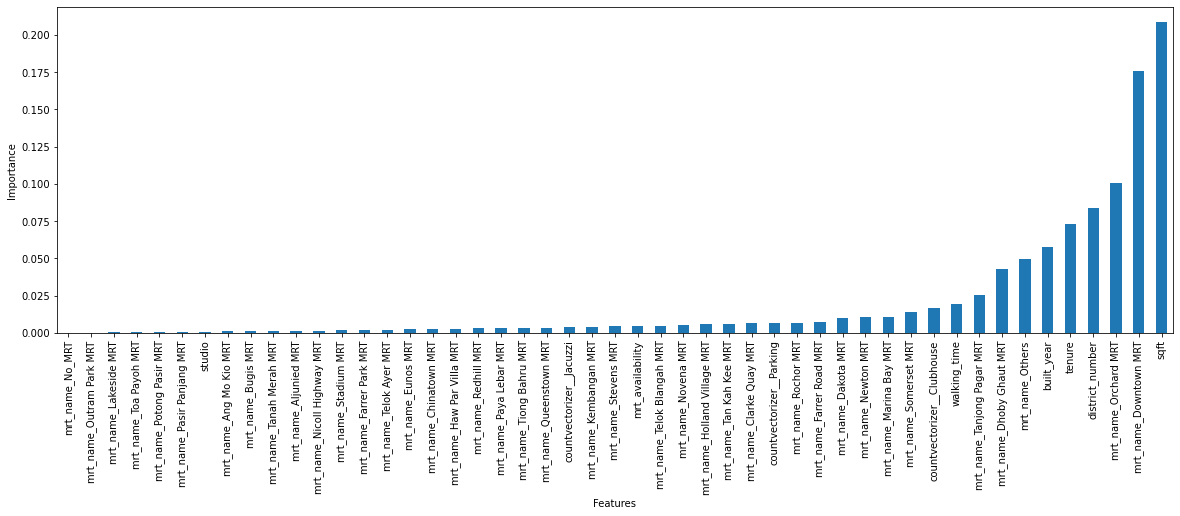

In [87]:
# importance of all features based of initial model

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

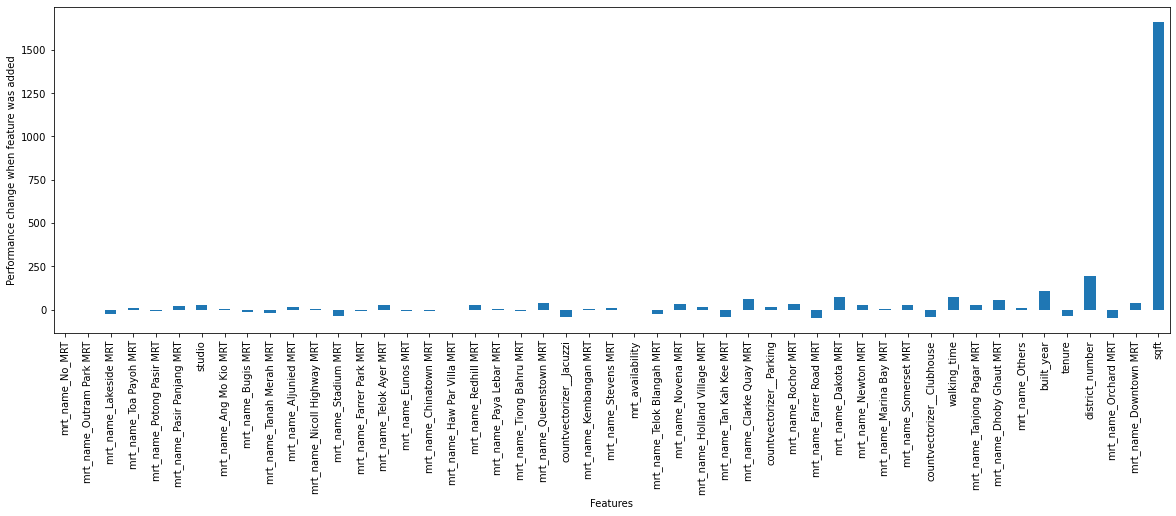

In [88]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [89]:
# Number of features that will be removed

len(sel.features_to_drop_)

42

In [92]:
X_train = sel.transform(X_train)

In [96]:
cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

-1503.9138884261681

# Final Hyperameter Tuning via Optuna

Previously we have perform gridsearch for the hyperparameter for gridsearch, however it is not exhaustive as full gridsearch is computationally intensive. Here, we will be using Optuna for hyperparameter tuning. It is an optimization hyperparameter tuning that explore the space of hyperparamter.

This is the hyperparameter response space, the function we want to optimize.

In [98]:
def objective(trial):

    eta = trial.suggest_float("eta", 1e-2, 0.3, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100)
    subsample = trial.suggest_float("subsample", 0.1, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    
    model = XGBRegressor(random_state=0,
                         n_estimators = 200,
                         tree_method = 'gpu_hist',
                         predictor = 'gpu_predictor',
                         eta = eta,
                         reg_lambda = reg_lambda,
                         reg_alpha = reg_alpha,
                         subsample = subsample,
                         colsample_bytree = colsample_bytree,
                         max_depth = max_depth,
                         )

    score = cross_val_score(model, X_train, y_train, scoring = 'neg_root_mean_squared_error',  cv=5)
    accuracy = score.mean()
    return accuracy